# Plot global and relative sea level change

In [1]:
# Don't display filter warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import glob
import os

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
exp_path = '/home/jt1187/facts/myexperiments'

## Bob's old datasets
#rootdir = '/projects/kopp/facts-experiments/'
#exp_date  = 221217
#exp_path = os.path.join(rootdir,str(exp_date))

# List of scenarios to load
scenarios = ['ssp585']

# List of components and corresponding module to be used
components = ['AIS','GrIS_GIS','glaciers','landwaterstorage','sterodynamics','verticallandmotion']

# Pick corresponding modules (must be in the same sequence as components)
#modules = ['ipccar5', 'FittedISMIP', 'ipccar5', 'ssp' , 'tlm', 'kopp14'] # wf1f
#modules = ['larmip', 'FittedISMIP', 'ipccar5', 'ssp' , 'tlm', 'kopp14'] # wf2f
#modules = ['bamber19', 'bamber19', 'ipccar5', 'ssp' , 'tlm', 'kopp14'] # wf4

# Custom (wf2f, but use emulandice for AIS)
modules = ['emulandice', 'FittedISMIP', 'ipccar5', 'ssp' , 'tlm', 'kopp14'] # wf2f*

# Global, local or both (*)
ext = '*' # global, local, *

# Variable name in netcdf files
var = 'sea_level_change'

yr_st = 2020
yr_ed = 2100

In [4]:
ddict = {s:{} for s in scenarios}
das = []
for scenario in scenarios:
    print('\n',scenario)
    head = 'coupling.%s'%scenario
    data_path = exp_path+'/'+head+'/output/'
    for i,component in enumerate(components):
        if modules[i] in ['bamber19','ipccar5']:
            if component=='AIS':
                component_str = 'icesheets_'+component if modules[i]=='bamber19' else 'icesheets_*'+component
            elif component=='GrIS_GIS':
                component_str = 'icesheets_'+component.split('_')[-1]
            else:
                component_str = component
        else:
            component_str = component   
                
        # In case of ipccar5, localsl is missing for AIS -> Get WAIS and EAIS instead
        #if (modules[i]=='ipccar5') & (component=='AIS'):
        #    print(head+'.*.%s.%s_%ssl.nc'%(modules[i],component,ext))
                
        file_str = head+'.*.%s.%s_%ssl.nc'%(modules[i],component_str,ext)
        fnames = glob.glob(data_path+file_str)
        print('\n',component)
        for fname in fnames:
            component_ext = os.path.basename(fname).split('.')[-2].split('_')
            #print(component,component_ext)
            if (component!='GrIS_GIS') & (len(component_ext)>2) & (modules[i] not in ['bamber19','ipccar5']):
                continue
            print(os.path.basename(fname))
            #print(os.path.basename(fname).split('.')[-2].split('_'))
        print(file_str)
        
        # In case of ipccar5, localsl is missing for AIS -> Get WAIS and EAIS instead
        # and derived AIS by summing sea_level_change of WAIS and EAIS
        if (modules[i]=='ipccar5') & (component=='AIS'):
            das_subcomponent = []
            for subcomponent in ['EAIS','WAIS']:
                print(subcomponent)
                print([fname for fname in fnames if subcomponent in fname])
                print()
                fnames_subcomponent = [fname for fname in fnames if subcomponent in fname]
                ds_subcomponent = xr.open_mfdataset(fnames_subcomponent)
                da_subcomponent = ds_subcomponent[var]
                attrs = {**da_subcomponent.attrs, **ds_subcomponent.attrs}
                da_subcomponent['subcomponent'] = subcomponent
                das_subcomponent.append(da_subcomponent)
                
            da = xr.concat(das_subcomponent,dim='subcomponent').sum('subcomponent').rename(component)
            da.attrs = attrs  
        else:
            ds = xr.open_mfdataset(data_path+file_str)
            da = ds[var].rename(component)
            da.attrs = {**da.attrs, **ds.attrs}
            
        # No global file for VLM. Add all-zero array instead 
        if component=='verticallandmotion':
            da_g = xr.zeros_like(da.isel(locations=0)).squeeze().reset_coords(drop=True)
            da_g = da_g.expand_dims(dim='locations')
            da_g['locations'] = xr.DataArray([-1], dims='locations')
            da = xr.concat([da_g,da], dim='locations').transpose('samples','years','locations')
        
        da.attrs['module'] = modules[i]
        das.append(da)
        
    ds = xr.merge(das)
    
    # Clear the attributes
    ds.attrs = {}
    
    # Save to ddict
    ddict[scenario] = ds


 ssp585

 AIS
coupling.ssp585.emuAIS.emulandice.AIS_localsl.nc
coupling.ssp585.emuAIS.emulandice.AIS_globalsl.nc
coupling.ssp585.*.emulandice.AIS_*sl.nc

 GrIS_GIS
coupling.ssp585.GrIS1f.FittedISMIP.GrIS_GIS_localsl.nc
coupling.ssp585.GrIS1f.FittedISMIP.GrIS_GIS_globalsl.nc
coupling.ssp585.*.FittedISMIP.GrIS_GIS_*sl.nc

 glaciers
coupling.ssp585.ar5glaciers.ipccar5.glaciers_globalsl.nc
coupling.ssp585.ar5glaciers.ipccar5.glaciers_localsl.nc
coupling.ssp585.*.ipccar5.glaciers_*sl.nc

 landwaterstorage
coupling.ssp585.lws.ssp.landwaterstorage_localsl.nc
coupling.ssp585.lws.ssp.landwaterstorage_globalsl.nc
coupling.ssp585.*.ssp.landwaterstorage_*sl.nc

 sterodynamics
coupling.ssp585.ocean.tlm.sterodynamics_localsl.nc
coupling.ssp585.ocean.tlm.sterodynamics_globalsl.nc
coupling.ssp585.*.tlm.sterodynamics_*sl.nc

 verticallandmotion
coupling.ssp585.k14vlm.kopp14.verticallandmotion_localsl.nc
coupling.ssp585.*.kopp14.verticallandmotion_*sl.nc


In [5]:
ds = ddict['ssp585'].sel(years=slice(yr_st,yr_ed))

In [6]:
sum_of_components = xr.zeros_like(ds[component]).rename('sum_of_components')
sum_of_components.attrs = {}
for v in list(ds.keys()):
    sum_of_components += ds[v]

In [7]:
ds_qt = ds.quantile((0.05, 0.17, 0.5, 0.9, 0.83, 0.95), dim='samples')

## Stackplots

In [8]:
clrs = ['tab:red', 'lightseagreen', 'tab:green', 'm','royalblue','y']

### Global sea level

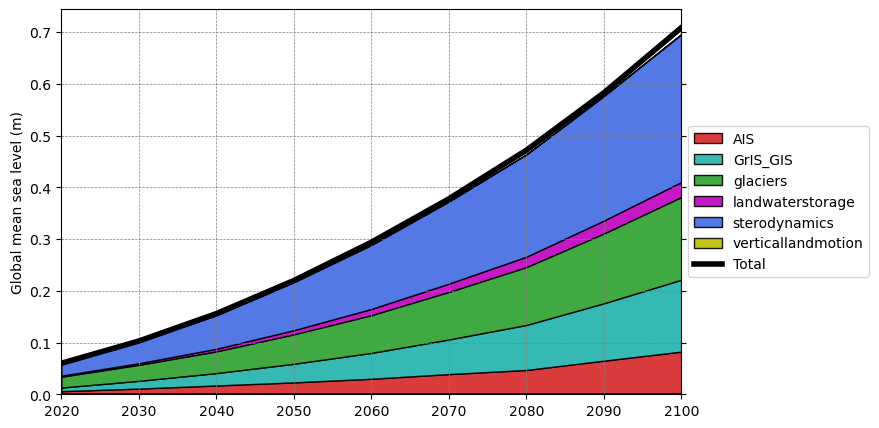

In [9]:
loc_idx = -1
qtile = 0.5

da_vars = ds_qt.sel(locations=loc_idx,quantile=qtile).to_array()
total = sum_of_components.quantile(qtile, dim='samples').sel(locations=loc_idx)
yrs = da_vars.years.values
var = da_vars.variable.values

var_pos = np.where(var < 0, 0, var)
var_neg = np.where(var >= 0, 0, var)

fig, ax = plt.subplots(figsize=(8,5))
ax.stackplot(yrs, np.vstack(var_pos)/1000, colors=clrs,alpha=0.9,ec='k',lw=1)
ax.stackplot(yrs, np.vstack(var_neg)/1000, labels=da_vars.coords['variable'].values,
               colors=clrs,alpha=0.9,ec='k',lw=1)
ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(yrs, total.values/1000,c='k',lw=4, label='Total')
ax.set_xlim([2020,2100])
ax.set_ylabel('Global mean sea level (m)')
ax.tick_params(axis='both', labelsize=10)
ax.yaxis.set_ticks_position('both')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(which='major', color='grey', linestyle='--', linewidth=0.5)

plt.show()

### Relative sea-level

#### Single location

In [10]:
loc_idx=43
da_vars = ds_qt.sel(locations=loc_idx,quantile=qtile).to_array()
total = sum_of_components.quantile(qtile, dim='samples').sel(locations=loc_idx)
yrs = da_vars.years.values
var = da_vars.variable.values

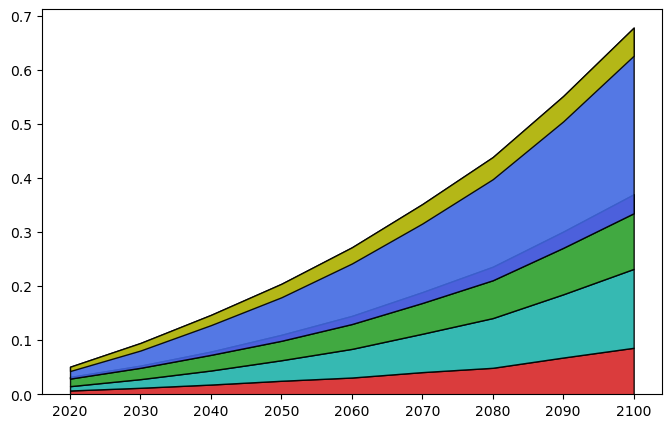

In [11]:
fig, ax = plt.subplots(figsize=(8,5))
ax.stackplot(yrs, np.vstack(var)/1000, labels=da_vars.coords['variable'].values,
             colors=clrs,alpha=0.9,ec='k',lw=1)
plt.show()

*Note*: Default `stackplot` does not display contributions of negative values accurately. Need to plot positive and negative values seperatley.

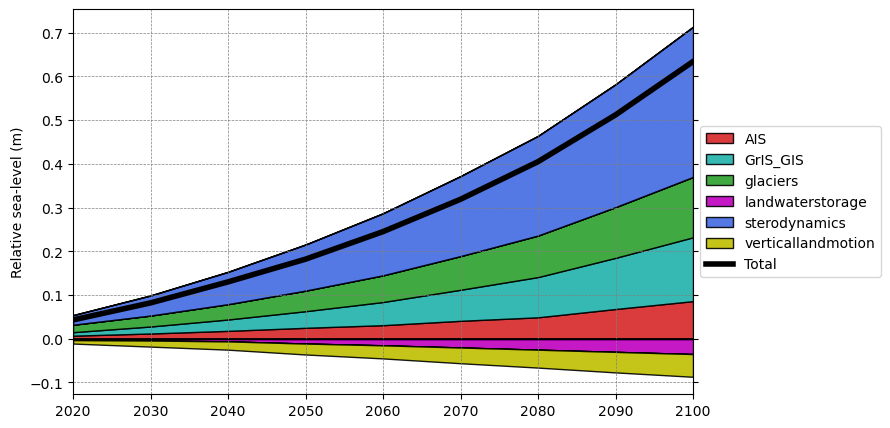

In [12]:
var_pos = np.where(var < 0, 0, var)
var_neg = np.where(var >= 0, 0, var)

fig, ax = plt.subplots(figsize=(8,5))
ax.stackplot(yrs, np.vstack(var_pos)/1000, colors=clrs,alpha=0.9,ec='k',lw=1)
ax.stackplot(yrs, np.vstack(var_neg)/1000, labels=da_vars.coords['variable'].values,
               colors=clrs,alpha=0.9,ec='k',lw=1)
ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(yrs, total.values/1000,c='k',lw=4, label='Total')
ax.set_xlim([2020,2100])
ax.set_ylabel('Relative sea-level (m)')
ax.tick_params(axis='both', labelsize=10)
ax.yaxis.set_ticks_position('both')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(which='major', color='grey', linestyle='--', linewidth=0.5)

plt.show()

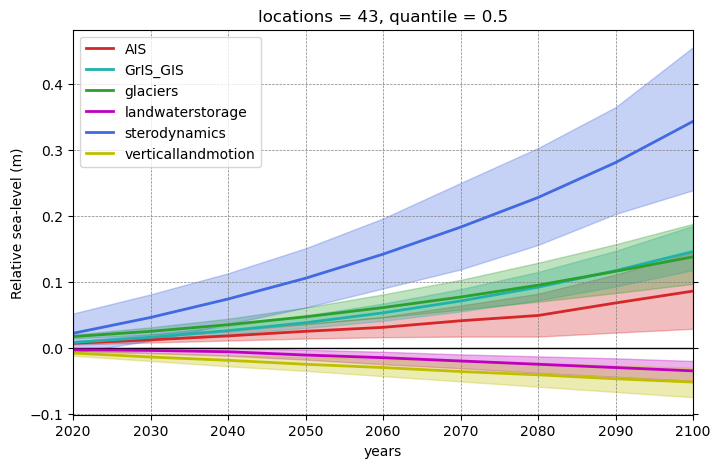

In [13]:
fig, ax = plt.subplots(figsize=(8,5))
ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
for i, v in enumerate(list(ds.keys())):
    ax.fill_between(ds_qt.years, ds_qt[v].sel(locations=loc_idx, quantile=0.17)/1000, 
                    ds_qt[v].sel(locations=loc_idx, quantile=0.83)/1000, 
                    alpha=0.3, edgecolor=clrs[i], facecolor=clrs[i])
    (ds_qt[v]/1000).sel(locations=loc_idx, quantile=qtile).plot(ax=ax,c=clrs[i],lw=2,label=v)
ax.set_xlim([2020, 2100])
ax.set_ylabel('Relative sea-level (m)')
ax.tick_params(axis='both', labelsize=10)
ax.yaxis.set_ticks_position('both')
ax.legend(loc='upper left')
ax.grid(which='major', color='grey', linestyle='--', linewidth=0.5)

plt.show()

#### Multiple locations

In [14]:
# Load location file
df_loc = pd.read_csv('/home/jt1187/facts/input_files/location.lst', header=None, sep='\t',
                     names=['name', 'id', 'lat', 'lon'])

# Remove the rows that start with "grid_" in the name column
df_loc = df_loc[~df_loc['name'].str.startswith("grid_")]

In [15]:
#locs = ['WILMINGTON','FORT_MYERS','NEW_YORK']
#locs = ['BAR_HARBOR','NEW_YORK','WILMINGTON','FORT_MYERS']
locs = ['BAR_HARBOR','NEW_YORK','WILMINGTON','FORT_MYERS',
        'BERGEN', 'DUBLIN', 'DOVER', 'BREST',
        'MIYAKO_I', 'KUSHIMOTO', 'BUSAN', 'KANMEN']

df_loc[df_loc['name'].isin(locs)]

,name,id,lat,lon
0,BREST,1,48.38,-4.49
9,NEW_YORK,12,40.70,-74.01
43,BERGEN,58,60.40,5.32
96,KUSHIMOTO,134,33.48,135.77
174,DOVER,255,51.11,1.32
239,WILMINGTON,396,34.23,-77.95
263,DUBLIN,432,53.35,-6.22
284,MIYAKO_I,463,39.63,141.97
324,BAR_HARBOR,525,44.39,-68.20
547,KANMEN,934,28.08,121.28


In [16]:
locations = list(df_loc[df_loc['name'].isin(locs)].id.values)

In [17]:
n = len(locations)

# Calculate the number of columns
ncols = int(np.ceil(np.sqrt(n)))

# Calculate the number of rows
nrows = int(np.ceil(n / ncols))

if n <= 2:
    figsize = (8, 4)
else:
    figsize = (18,12)

Bar Harbor
New York
Wilmington
Fort Myers
Bergen
Dublin
Dover
Brest
Miyako I
Kushimoto
Busan
Kanmen


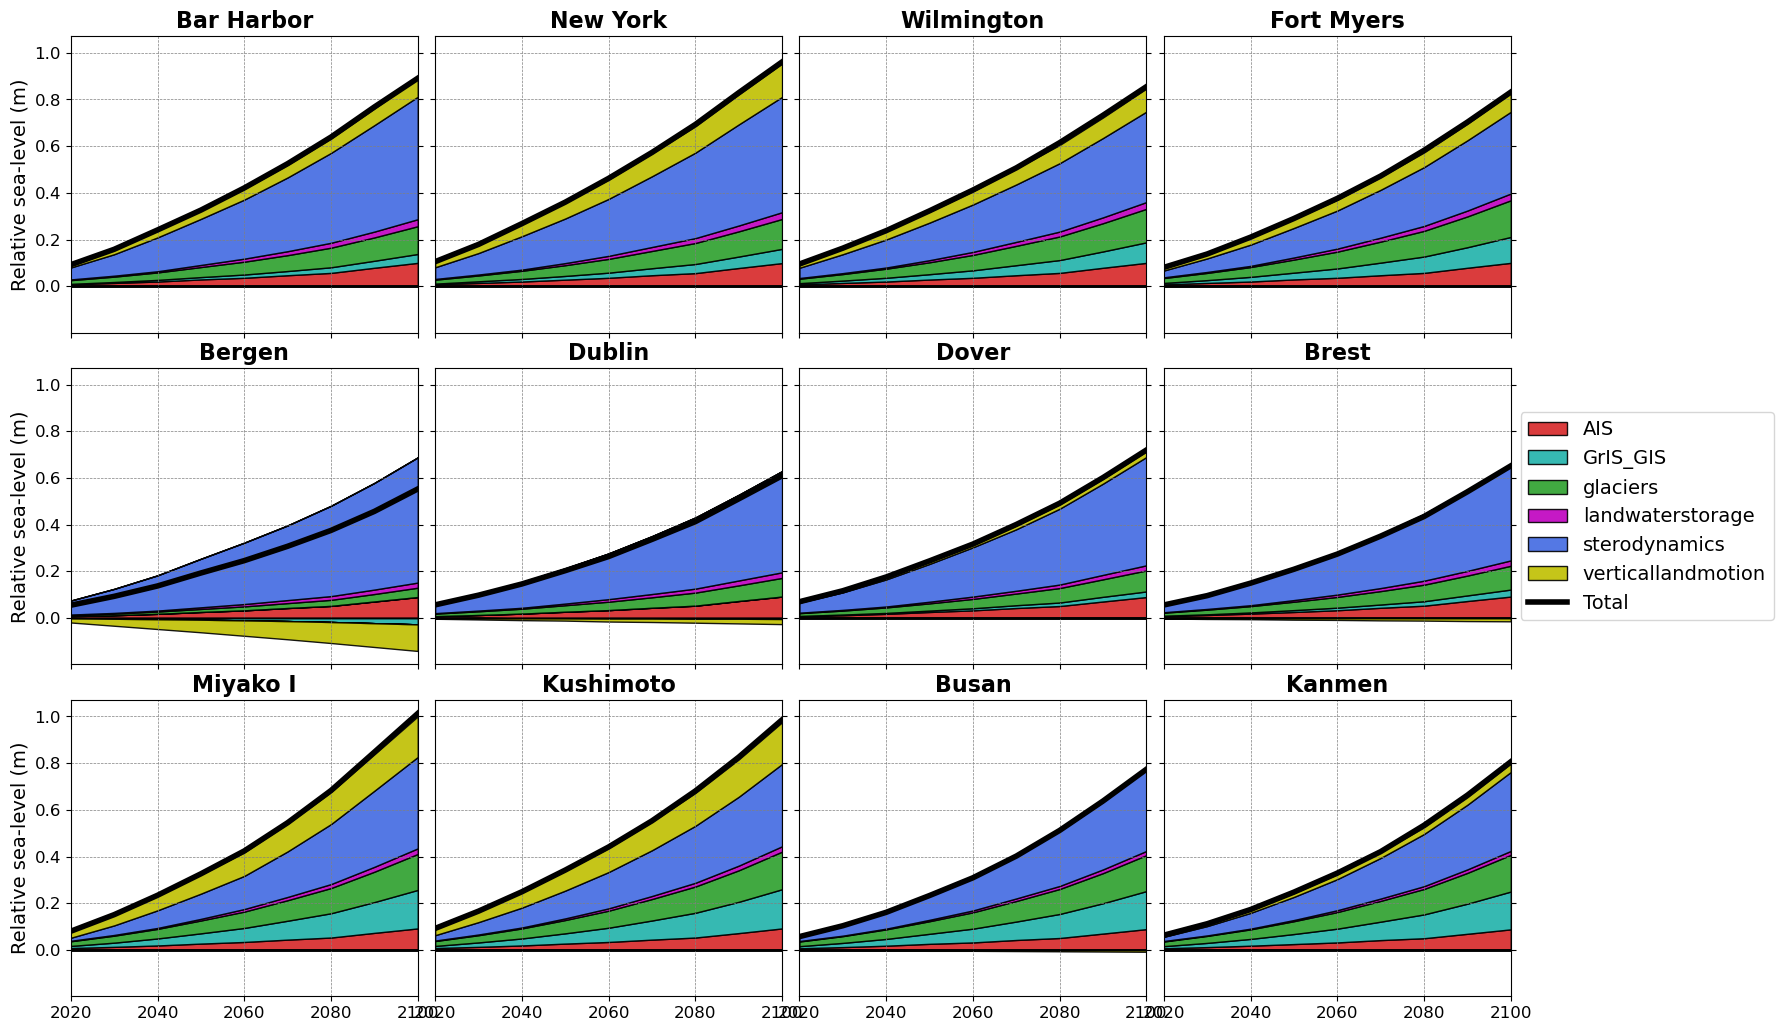

In [20]:
qtile = 0.5

fig, axs = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=figsize)
fig.subplots_adjust(left=0.1, right=0.90, bottom=0.1, top=0.9, hspace=0.12, wspace=0.05)
axs = axs.flatten()

for i, loc in enumerate(locs):
    loc_idx = df_loc[df_loc['name']==loc].id.values[0]
    da_vars = ds_qt.sel(locations=loc_idx,quantile=qtile).to_array()
    total = sum_of_components.quantile(qtile, dim='samples').sel(locations=loc_idx)
    yrs = da_vars.years.values
    var = da_vars.variable.values
    
    var_pos = np.where(var < 0, 0, var)
    var_neg = np.where(var >= 0, 0, var)
    
    ax = axs[i] if n>1 else axs
    ax.stackplot(yrs, np.vstack(var_pos)/1000, colors=clrs,alpha=0.9,ec='k',lw=1)
    p = ax.stackplot(yrs, np.vstack(var_neg)/1000, labels=da_vars.coords['variable'].values,
                      colors=clrs,alpha=0.9,ec='k',lw=1)
    ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
    l = ax.plot(yrs, total.values/1000,c='k',lw=4, label='Total')
    ax.set_xlim([2020, 2100])
    if i % ncols == 0:
        ax.set_ylabel('Relative sea-level (m)', fontsize=14)
        
    if (i + 1) % ncols == 0:
        ax.set_xticks(np.arange(2020,2120,20))
    else:
        ax.set_xticks(np.arange(2020,2100,20))
        
    ax.tick_params(axis='both', labelsize=12)
    ax.yaxis.set_ticks_position('both')
    ax.grid(which='major', color='grey', linestyle='--', linewidth=0.5)
    ax.set_title(df_loc[df_loc.id==loc_idx].name.values[0].replace('_',' ').title(), fontsize=16, fontweight='bold')
    print(df_loc[df_loc.id==loc_idx].name.values[0].replace('_',' ').title())
    

# Add a single legend to the figure
lab_p = [p_i.get_label() for p_i in p]
lab_l = [l_i.get_label() for l_i in l]
lab = lab_p+lab_l
hdl = p+l
fig.legend(hdl,lab, loc='center left', bbox_to_anchor=(0.9, 0.5), fontsize=14)
plt.savefig('/home/jt1187/figure.png', dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', format='png',transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()

Bar Harbor
New York
Wilmington
Fort Myers
Bergen
Dublin
Dover
Brest
Miyako I
Kushimoto
Busan
Kanmen


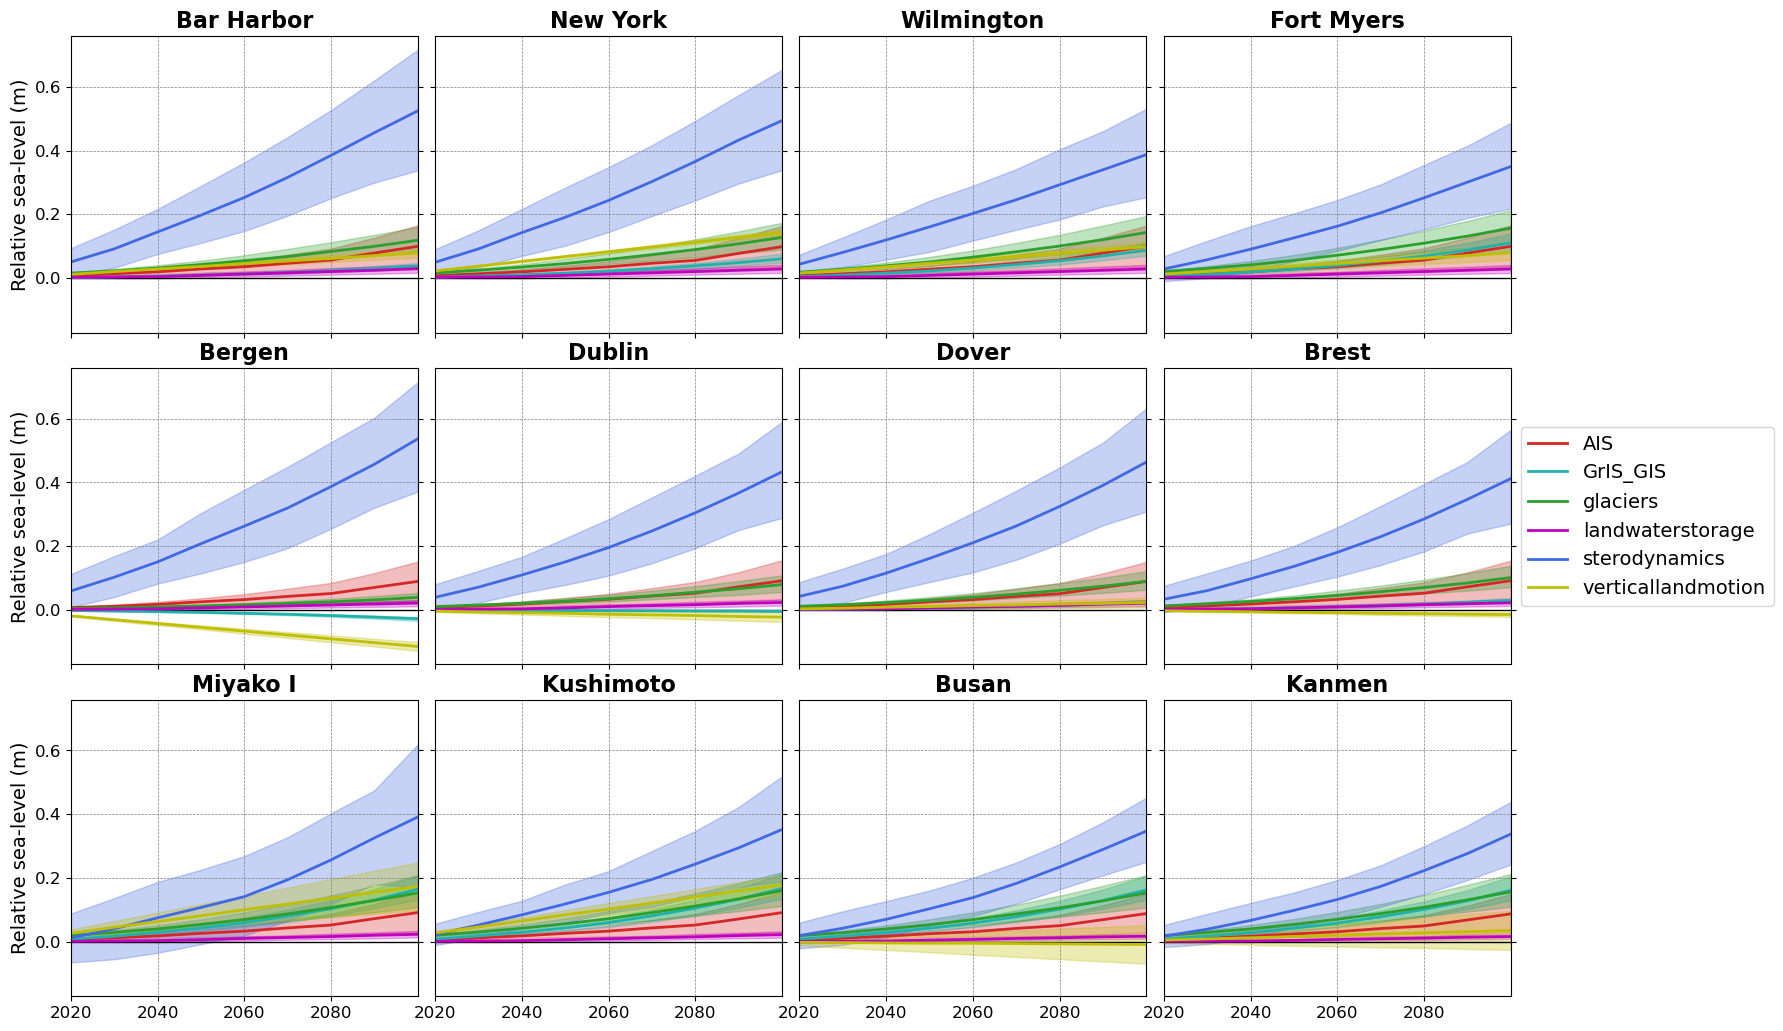

In [21]:
fig, axs = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=figsize)
fig.subplots_adjust(left=0.1, right=0.90, bottom=0.1, top=0.9, hspace=0.12, wspace=0.05)
axs = axs.flatten()

for i, loc in enumerate(locs):
    loc_idx = df_loc[df_loc['name']==loc].id.values[0]
    print(df_loc[df_loc.id==loc_idx].name.values[0].replace('_',' ').title())
   
    ax = axs[i] if n>1 else axs
    ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
    hdl = []
    for j, v in enumerate(list(ds.keys())):
        ax.fill_between(ds_qt.years, ds_qt[v].sel(locations=loc_idx, quantile=0.17)/1000, 
                        ds_qt[v].sel(locations=loc_idx, quantile=0.83)/1000, 
                        alpha=0.3, edgecolor=clrs[j], facecolor=clrs[j])
        p, = (ds_qt[v]/1000).sel(locations=loc_idx, quantile=qtile).plot(ax=ax,c=clrs[j],lw=2,
                                                                         _labels=None, label=v)
        hdl.append(p)
    ax.set_xlim([2020, 2100])
    ax.set_xticks(np.arange(2020,2100,20))
    
    if i % ncols == 0:
        ax.set_ylabel('Relative sea-level (m)', fontsize=14)
          
    ax.tick_params(axis='both', labelsize=12)
    ax.yaxis.set_ticks_position('both')
    ax.grid(which='major', color='grey', linestyle='--', linewidth=0.5)
    ax.set_title(df_loc[df_loc.id==loc_idx].name.values[0].replace('_',' ').title(), fontsize=16, fontweight='bold')

fig.legend(handles=hdl, loc='center left', bbox_to_anchor=(0.9, 0.5), fontsize=14)
plt.savefig('/home/jt1187/figure.png', dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', format='png',transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()

## Map

In [22]:
import cartopy

In [23]:
qtile = 0.5
var_SD = ds_qt.sel(quantile=qtile,years=2100).sterodynamics

In [24]:
df_SD = var_SD.isel(locations=slice(1,None)).reset_coords(drop=True).to_dataframe().reset_index()\
            .rename(columns={'locations': 'id'})

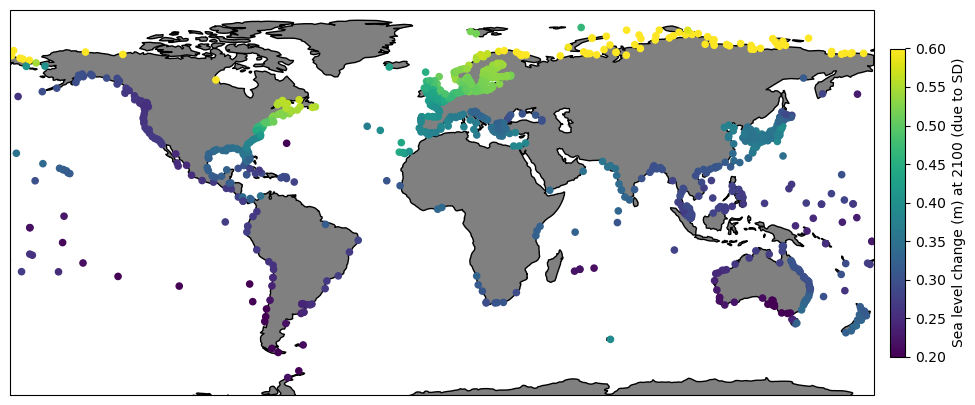

In [25]:
fig = plt.figure(figsize=[15, 5])
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black', facecolor='grey')

p = ax.scatter(df_loc.lon.values, df_loc.lat.values, transform=cartopy.crs.PlateCarree(),
               c=df_SD.sterodynamics.values/1000, s=20, vmin=0.2, vmax=0.6)

# Add separate colorbar
cb = fig.colorbar(p, shrink=0.8, pad=0.014, orientation='vertical')
cb.set_label('Sea level change (m) at 2100 (due to SD)')

plt.savefig('/home/jt1187/figure.png', dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', format='png',transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()

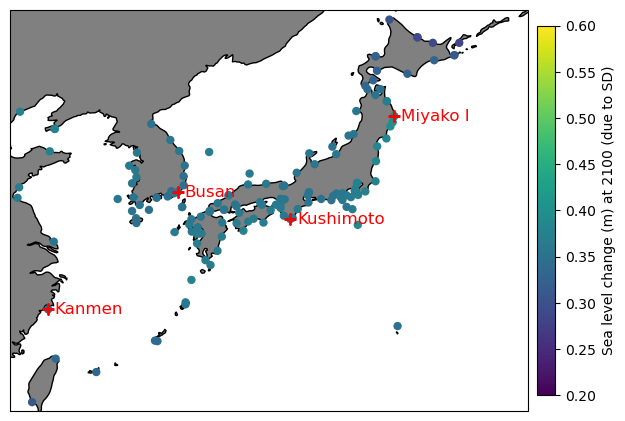

In [26]:
# US east coast
#locs = ['BAR_HARBOR','NEW_YORK','WILMINGTON','FORT_MYERS']
#west, east, north, south = -83.0,  -63.0, 24.0, 46.0 
#fig = figsize=[7, 8]


# Europe
#locs = ['BERGEN', 'DUBLIN', 'DOVER', 'BREST']
#west, east, south, north = -13, 30, 35, 73
#figsize=[8, 7]

# East Asia coast
locs = ['MIYAKO_I', 'KUSHIMOTO', 'BUSAN', 'KANMEN']
west, east, south, north = 119, 150, 22, 46
fig = figsize=[8, 6]

fig = plt.figure(figsize=figsize)
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.set_extent([west, east, south, north], cartopy.crs.PlateCarree())
ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black', facecolor='grey')
p = ax.scatter(df_loc.lon.values, df_loc.lat.values, transform=cartopy.crs.PlateCarree(),
               c=df_SD.sterodynamics.values/1000, s=25, vmin=0.2, vmax=0.6)

ax.plot(df_loc[df_loc['name'].isin(locs)].lon.values, df_loc[df_loc['name'].isin(locs)].lat.values, 
        transform=cartopy.crs.PlateCarree(), marker='+', color='r', markersize=8, linestyle='',
        markeredgewidth=2, label='Tide gauge')

# Add name for each tide gauge
for idx in range(0,len(df_loc[df_loc['name'].isin(locs)])):
    ax.text(df_loc[df_loc['name'].isin(locs)].iloc[idx].lon+0.4, df_loc[df_loc['name'].isin(locs)].iloc[idx].lat, 
            df_loc[df_loc['name'].isin(locs)].iloc[idx]['name'].replace('_',' ').title(), 
            color='r', fontsize=12, va='center', ha='left')

# Add separate colorbar
cb = fig.colorbar(p, shrink=0.8, pad=0.014, orientation='vertical')
cb.set_label('Sea level change (m) at 2100 (due to SD)')
plt.savefig('/home/jt1187/figure.png', dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', format='png',transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()